In [1]:
import re 
import pandas as pd
from datetime import date
from analytics_utils.bigquery_utils import get_bq_client, BigQuery
import plotly.graph_objects as go
pd.options.plotting.backend = "plotly"

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'notebook'

import ipywidgets as widgets
from IPython.display import display, clear_output

STAGE_MAP = {
    'New': 1, 'Review': 2, 'Marked Relevant': 4, 
    'Opened': 2, 'Clicked': 2, 'Delivered': 4, 
    'Suppressed': 3, 'Dismissed': 3
}

REVERSE_STAGE_MAP = {
    1: 'New',
    2: 'Review',
    3: 'Dismissed',
    4: 'Marked Relevant'
}

DIM_MAP = {
    'Client': "fetch_recommendation_activity_customer", 
    'Client Industry': "Industry", 
    'Req Seniority': "dim_req_required_seniority_level", 
    'Req Top Category': "dim_req_top_category_calculated"
}

client_industry = pd.read_excel('planhat-companies-Oct-29-2023.xlsx')

In [2]:
# Function to read cached dates from a local text file
def read_cached_dates():
    try:
        with open('cached_dates.txt', 'r') as file:
            cached_dates = file.read().split(',')
            cached_from = date.fromisoformat(cached_dates[0])
            cached_to = date.fromisoformat(cached_dates[1])
            return cached_from, cached_to
    except FileNotFoundError:
        return None, None

# Function to write current dates to a local text file
def write_cached_dates(from_date, to_date):
    with open('cached_dates.txt', 'w') as file:
        file.write(f"{from_date.isoformat()},{to_date.isoformat()}")
        
PATTERN_DELETE = r'(?=.+posit.+fill.+)|(?=.+posit.+interna.+)|(?=.+terna.+nly.+)|(?=.+interna.+fill.+)|(?=.+cand.+not.+interested.+)|(?=.+not.+reach.+)|(?=.+reach.+not.+)|(?=.+urrent.+employ.+)|(?=.*\bprocess\b.*\banother\b.*\breq\b)'

REASONS_TO_FILTER = {
    'other: Position will be filled internally ',
    'Candidate invited to apply',
    'In process in another req ',
    'Current Employee',
    'other: Position filled',
    'other: Internal only',
    'Qualified but candidate not interested at this time',
    
}

REASONS_TO_FILTER = {x.lower().strip() for x in REASONS_TO_FILTER}

def check_id(user_id):
    if user_id:
        if 'test' in user_id:
            return False
        elif str(user_id).endswith('-1'):
            return False
    return True



In [14]:
def get_dataframe(from_date, to_date):
    cached_from, cached_to = read_cached_dates()

    if cached_from and cached_to and cached_from <= from_date <= to_date <= cached_to and False:
        print("Data already cached for the requested date range. Loading..")
        df = pd.read_csv('cache_dump.csv')
        df['Date'] = pd.to_datetime(df['fact_recommendation_status_history_status_at_date'])
        return df[(df['Date'].dt.date >= from_date) & (df['Date'].dt.date <= to_date)]
    else:
        print("Big Query data request is required. Please, wait...")
        db_client = get_bq_client('production')
        sql = f"""
            SELECT
                fact_recommendation_status_history.analytics_fetch_status_bucket  AS fact_recommendation_status_history_fetch_bucket,
                fetch_recommendation_activity.req_id  AS fetch_recommendation_activity_req_id,
                fetch_recommendation_activity.talent_id  AS fetch_recommendation_activity_talent_id,
                fact_recommendation_status_history.reason  AS fact_recommendation_status_history_reason,
                (DATE(fact_recommendation_status_history.status_ts )) AS fact_recommendation_status_history_status_at_date,
                fetch_recommendation_activity.customer  AS fetch_recommendation_activity_customer,
                dim_req.required_seniority_level  AS dim_req_required_seniority_level,
                dim_req.top_category  AS dim_req_top_category_calculated,
                fact_recommendation_status_history.user_id  AS fact_recommendation_status_history_user_id
            FROM `hs-analytics.all_customers.dwh_hs_dim_recommendation`
                 AS fetch_recommendation_activity
            LEFT JOIN `hs-analytics.all_customers.dwh_hs_fact_recommendation_status_history`
                 AS fact_recommendation_status_history ON fetch_recommendation_activity.key = fact_recommendation_status_history.recommendation_key
                and fetch_recommendation_activity.customer = fact_recommendation_status_history.customer
            FULL OUTER JOIN `hs-analytics.all_customers.dwh_hs_dim_req`
                 AS dim_req ON dim_req.key = fetch_recommendation_activity.req_key
                and dim_req.customer = fetch_recommendation_activity.customer
            WHERE (fact_recommendation_status_history.analytics_fetch_status_bucket ) IN ('Dismissed', 'Marked Relevant', 'Review') 
                AND ((( fact_recommendation_status_history.status_ts  ) >= (TIMESTAMP("{str(from_date)}")) 
                AND ( fact_recommendation_status_history.status_ts  ) < (TIMESTAMP("{str(to_date)}")))) 
                AND (fetch_recommendation_activity.customer not in ( 'princeton',
                     'arizona_wd_staging',
                     'antigua',
                     'havana',
                     'seoul_icims',
                     'arizona' ))
            GROUP BY
                1,
                2,
                3,
                4,
                5,
                6,
                7,
                8,
                9
        """
        job_result = db_client.execute(sql)
        df = job_result['query_reults'].to_dataframe()
        df.to_csv('cache_dump.csv', index=None)
        write_cached_dates(from_date, to_date)
        df['Date'] = pd.to_datetime(df['fact_recommendation_status_history_status_at_date'])
        return df
    
def prepare_df(df):
    calc_df = df.copy()

    calc_df['Date'] = pd.to_datetime(calc_df['fact_recommendation_status_history_status_at_date'])
    for period in ('M', 'W', '2W'):
        calc_df[f'Period {period}'] = calc_df['Date'].dt.to_period(period)

    calc_df['bucket_code'] = calc_df['fact_recommendation_status_history_fetch_bucket'].map(STAGE_MAP)
    calc_df['pair_id'] = calc_df['fetch_recommendation_activity_req_id'].fillna('nan') + '_' + calc_df['fetch_recommendation_activity_talent_id'].fillna('nan')

    leads_to_filter = set(calc_df[
        calc_df['fact_recommendation_status_history_reason'].fillna('').apply(
            lambda x: (bool(re.findall(PATTERN_DELETE, x.lower())) and ('qualif' not in x.lower())) or x.lower().strip() in REASONS_TO_FILTER
        )
    ]['pair_id'].values)


    calc_df[
        calc_df['fact_recommendation_status_history_reason'].fillna('').apply(
            lambda x: (bool(re.findall(PATTERN_DELETE, x.lower())) and ('qualif' not in x.lower())) or x.lower().strip() in REASONS_TO_FILTER
        )
    ]['bucket_code'] = STAGE_MAP['Marked Relevant']

    calc_df = calc_df[
        (~calc_df['pair_id'].isin(leads_to_filter)) & 
        (calc_df['fact_recommendation_status_history_user_id'].fillna('').apply(check_id))
    ]
    grouped_df = calc_df.groupby(
        ['pair_id'], as_index=False
    ).agg(
        {"bucket_code": "max",
         'fetch_recommendation_activity_req_id': 'first',
         'fetch_recommendation_activity_talent_id': 'first',
         'fetch_recommendation_activity_customer': 'first',
         'fact_recommendation_status_history_user_id': 'first',
         'Date': 'max',
         'Period M': 'max',
         'Period W': 'max',
         'Period 2W': 'max',     
         'dim_req_top_category_calculated': 'first',
         'dim_req_required_seniority_level': 'first',
        })

    grouped_df['Max Status Bucket'] = grouped_df['bucket_code'].map(REVERSE_STAGE_MAP)
    grouped_df = pd.concat([grouped_df, pd.get_dummies(grouped_df['Max Status Bucket'])], axis=1)
    grouped_df = grouped_df.dropna(subset=['Max Status Bucket'])

    client_industry['Account Name'] = client_industry['Account Name'].str.lower()
    grouped_df = pd.merge(grouped_df, client_industry, 
                          left_on='fetch_recommendation_activity_customer', 
                          right_on='Account Name', how='left')
    return grouped_df

In [4]:
def aggregate_by_field(grouped_df, date_level, average='macro', dimension=None, accounts=None):
    #if accounts:
    #    grouped_df = grouped_df[grouped_df['fetch_recommendation_activity_customer'].isin(accounts)]
    grouped_df[f'Period {date_level}'] = grouped_df['Date'].dt.to_period(date_level)
    if average == 'macro':
        cols_gr_by = [f'Period {date_level}', dimension]
    elif average == 'micro':
        cols_gr_by = [f'Period {date_level}']
    agg_df = grouped_df.groupby(
        cols_gr_by, as_index=False)[
        ['Dismissed', 'Marked Relevant', 'Review']
    ].sum()
    agg_df['All'] = agg_df.sum(axis=1)
    agg_df['Conversion Rate'] = agg_df['Marked Relevant'] / (agg_df['Dismissed'].fillna(0) + agg_df['Marked Relevant'])

    for stage in ['Dismissed', 'Marked Relevant', 'Review']:
        agg_df[f'{stage} Rate'] = (agg_df[stage] / agg_df['All'])
    
    if average == 'macro':
        pivot_df = agg_df.groupby(f'Period {date_level}', as_index=False).agg({
            "Marked Relevant": "sum",
            "Dismissed": "sum",
            "Review": "sum",
            "All": "sum",
            "Conversion Rate": "mean",
            "Dismissed Rate": 'mean',
            "Marked Relevant Rate": "mean",
            "Review Rate": "mean",    
        })
    elif average == 'micro':
        pivot_df = agg_df
    pivot_df['Overall Propensity Rate'] = 1 - (pivot_df['Review'] / pivot_df[['Dismissed', 'Marked Relevant', 'Review']].sum(axis=1))
    fig = px.line(pivot_df, 
                  width=800, height=400,
              x=pivot_df[f'Period {date_level}'].astype(str), 
              y=['Conversion Rate', 'Dismissed Rate', 'Marked Relevant Rate', 
                 'Overall Propensity Rate'
                ], 
              title=f'Conversion Rate in 2023 (MacroAvg Across {dimension}) By {date_level} Periods')
    fig.update_layout(xaxis_title=date_level)
    return pivot_df, fig

In [5]:
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

def on_button_clicked(b):
    with out:
        clear_output()
        df = get_dataframe(from_date_picker.value, to_date_picker.value) 
        grouped_df = prepare_df(df)
        pivot_df, fig = aggregate_by_field(grouped_df, period.value, 
                                           average=averaging.value,
                                           dimension=DIM_MAP[dimension.value],
                                           accounts=accounts_w.value)
        fig.show()
        display(pivot_df)

# Creating widgets
from_date_picker = widgets.DatePicker(description='From')
to_date_picker = widgets.DatePicker(description='To')

averaging = widgets.RadioButtons(
    options=['macro', 'micro'],
    description='Averaging Approach:'
)

period = widgets.RadioButtons(
    options=['W', 'D', 'M'],
    description='Period Of Breakdown:'
)

dimension = widgets.RadioButtons(
    options=DIM_MAP.keys(),
    description='Dimension To Do Macro-Average Over:'
)

options = [f'Item {i}' for i in range(1, 41)]
accounts_w = widgets.SelectMultiple(
    options=sorted(client_industry['Account Name'].str.lower().unique().tolist()),
    description='Accounts To Evaluate On:',
    disabled=False
)

button = widgets.Button(description="Run function")
button.on_click(on_button_clicked)

out = widgets.Output()

# Displaying widgets
display(from_date_picker, to_date_picker, averaging, dimension, period, accounts_w, button, out)

DatePicker(value=None, description='From', step=1)

DatePicker(value=None, description='To', step=1)

RadioButtons(description='Averaging Approach:', options=('macro', 'micro'), value='macro')

RadioButtons(description='Dimension To Do Macro-Average Over:', options=('Client', 'Client Industry', 'Req Sen…

RadioButtons(description='Period Of Breakdown:', options=('W', 'D', 'M'), value='W')

SelectMultiple(description='Accounts To Evaluate On:', options=('aden', 'alabama', 'amman', 'antalya', 'antigu…

Button(description='Run function', style=ButtonStyle())

Output()

In [15]:
df = get_dataframe(date(2023, 10, 1), date(2024, 12, 28))


Big Query data request is required. Please, wait...


/var/folders/_p/8_m91crj199_rd7sndkxncc80000gp/T/ipykernel_67035/313005172.py:75: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
grouped_df = prepare_df(df)

In [183]:
dallas = grouped_df[(grouped_df['Account Name'] == 'jamaica')]
dallas.shape

(2050, 18)

/var/folders/_p/8_m91crj199_rd7sndkxncc80000gp/T/ipykernel_67035/1128151374.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/_p/8_m91crj199_rd7sndkxncc80000gp/T/ipykernel_67035/1128151374.py:13: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



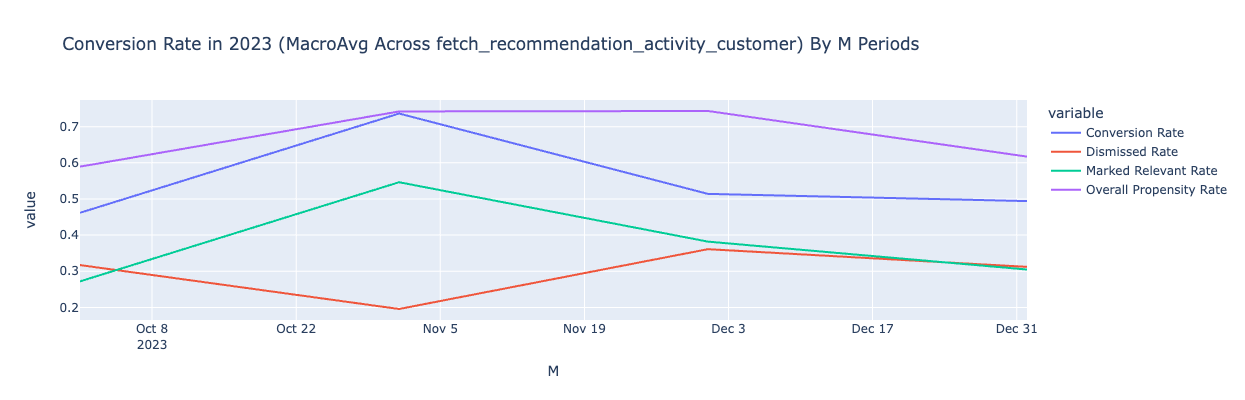

,Period M,Dismissed,Marked Relevant,Review,All,Conversion Rate,Dismissed Rate,Marked Relevant Rate,Review Rate,Overall Propensity Rate
0,2023-10,190.0,163.0,246.0,599.0,0.461756,0.317195,0.272120,0.410684,0.589316
1,2023-11,110.0,307.0,145.0,562.0,0.736211,0.195730,0.546263,0.258007,0.741993
2,2023-12,173.0,183.0,123.0,479.0,0.514045,0.361169,0.382046,0.256785,0.743215
3,2024-01,128.0,125.0,157.0,410.0,0.494071,0.312195,0.304878,0.382927,0.617073


In [185]:
pivot_df, fig = aggregate_by_field(dallas, 'M', 
                                   average='micro',
                                   dimension='fetch_recommendation_activity_customer',
                                   accounts=accounts_w.value)
fig.show()
display(pivot_df)

In [ ]:
grouped_df.columns

In [181]:
dallas = grouped_df[grouped_df['fetch_recommendation_activity_customer'] == 'dallas']
gb = ['Period M', 'fact_recommendation_status_history_user_id']

In [182]:
xdf = dallas.groupby(gb).sum()[['Marked Relevant', 'Dismissed', 'Review']].reset_index()
xdf['total'] = xdf['Marked Relevant'] + xdf['Dismissed'] + xdf['Review']
xdf['rate'] = xdf['Marked Relevant'] / xdf['total']
xdf.shape

(182, 7)

In [170]:
xdf['Period M'].nunique()

4

In [171]:
user_counts = xdf.groupby(['fact_recommendation_status_history_user_id'])['total'].count().reset_index()

In [172]:
relevant_users = user_counts['fact_recommendation_status_history_user_id'][user_counts['total'] >= 3]
len(relevant_users)

16

In [173]:
xdf = xdf[xdf['fact_recommendation_status_history_user_id'].isin(relevant_users)]

In [174]:
xdf.set_index(['Period M', 'fact_recommendation_status_history_user_id'])[['total']].unstack()

total                             \
fact_recommendation_status_history_user_id DEL15 DEL152 DEL222 DEL225 DEL24   
Period M                                                                      
2023-10                                     16.0   61.0   24.0   68.0   NaN   
2023-11                                     48.0   48.0   32.0   64.0  49.0   
2023-12                                      8.0    7.0  105.0   24.0   8.0   
2024-01                                      7.0   41.0   26.0   39.0  37.0   

                                                                              \
fact_recommendation_status_history_user_id DEL25 DEL421 DEL427 DEL456 DEL519   
Period M                                                                       
2023-10                                     12.0    8.0   60.0    5.0    7.0   
2023-11                                     33.0    7.0    NaN    1.0    7.0   
2023-12                                      3.0   16.0    4.0   19.0    NaN   
2024-01                                      NaN    NaN    8.0    8.0    1.0   

                                                                              \
fact_recommendation_status_history_user_id  DEL53 DEL666 DEL681 DEL73  DEL77   
Period M                                                                       
2023-10                                      78.0   89.0   24.0  97.0  140.0   
2023-11                                      57.0   17.0   14.0  93.0   19.0   
2023-12                                     128.0   16.0    1.0  56.0  108.0   
2024-01                                      48.0    8.0   15.0  37.0   31.0   

                                                  
fact_recommendation_status_history_user_id DEL98  
Period M                                          
2023-10                                      NaN  
2023-11                                      9.0  
2023-12                                     20.0  
2024-01                                      2.0

In [175]:
xdf.set_index(['Period M', 'fact_recommendation_status_history_user_id'])[['total']].unstack()

total                             \
fact_recommendation_status_history_user_id DEL15 DEL152 DEL222 DEL225 DEL24   
Period M                                                                      
2023-10                                     16.0   61.0   24.0   68.0   NaN   
2023-11                                     48.0   48.0   32.0   64.0  49.0   
2023-12                                      8.0    7.0  105.0   24.0   8.0   
2024-01                                      7.0   41.0   26.0   39.0  37.0   

                                                                              \
fact_recommendation_status_history_user_id DEL25 DEL421 DEL427 DEL456 DEL519   
Period M                                                                       
2023-10                                     12.0    8.0   60.0    5.0    7.0   
2023-11                                     33.0    7.0    NaN    1.0    7.0   
2023-12                                      3.0   16.0    4.0   19.0    NaN   
2024-01                                      NaN    NaN    8.0    8.0    1.0   

                                                                              \
fact_recommendation_status_history_user_id  DEL53 DEL666 DEL681 DEL73  DEL77   
Period M                                                                       
2023-10                                      78.0   89.0   24.0  97.0  140.0   
2023-11                                      57.0   17.0   14.0  93.0   19.0   
2023-12                                     128.0   16.0    1.0  56.0  108.0   
2024-01                                      48.0    8.0   15.0  37.0   31.0   

                                                  
fact_recommendation_status_history_user_id DEL98  
Period M                                          
2023-10                                      NaN  
2023-11                                      9.0  
2023-12                                     20.0  
2024-01                                      2.0

In [176]:
xdf.set_index(['Period M', 'fact_recommendation_status_history_user_id'])[['rate']].unstack()

rate                          \
fact_recommendation_status_history_user_id     DEL15    DEL152 DEL222 DEL225   
Period M                                                                       
2023-10                                     0.250000  0.049180    0.0    0.0   
2023-11                                     0.145833  0.041667    0.0    0.0   
2023-12                                     0.500000  0.000000    0.0    0.0   
2024-01                                     0.571429  0.000000    0.0    0.0   

                                                                       \
fact_recommendation_status_history_user_id     DEL24     DEL25 DEL421   
Period M                                                                
2023-10                                          NaN  0.083333    0.0   
2023-11                                     0.000000  0.030303    0.0   
2023-12                                     0.000000  0.000000    0.0   
2024-01                                     0.027027       NaN    NaN   

                                                                          \
fact_recommendation_status_history_user_id    DEL427    DEL456    DEL519   
Period M                                                                   
2023-10                                     0.016667  0.000000  0.142857   
2023-11                                          NaN  1.000000  1.000000   
2023-12                                     1.000000  0.315789       NaN   
2024-01                                     0.250000  0.375000  0.000000   

                                                                             \
fact_recommendation_status_history_user_id DEL53 DEL666    DEL681     DEL73   
Period M                                                                      
2023-10                                      0.0  0.000  0.000000  0.010309   
2023-11                                      0.0  0.000  0.000000  0.000000   
2023-12                                      0.0  0.125  0.000000  0.000000   
2024-01                                      0.0  0.000  0.066667  0.000000   

                                                            
fact_recommendation_status_history_user_id     DEL77 DEL98  
Period M                                                    
2023-10                                     0.000000   NaN  
2023-11                                     0.000000   0.0  
2023-12                                     0.037037   0.0  
2024-01                                     0.000000   0.0